# Fine-Tuning BERT on GLUE - STSB

From [Archive.org snapshot of dataset homepage](https://web.archive.org/web/20240319092902/http://ixa2.si.ehu.eus/stswiki/index.php/STSbenchmark):

STS Benchmark comprises a selection of the English datasets used in the STS tasks organized in the context of SemEval between 2012 and 2017. The selection of datasets include text from image captions, news headlines and user forums. 

## 0. Configuration

In [1]:
import os

# Where to store the huggingface data. On the provided Jupyterlab instance that should be within the shared group folder.
os.environ['HF_HOME'] = '../groups/192.039-2024W/bert/huggingface/cache'

In [2]:
from pathlib import Path

from transformers import set_seed

# RANDOMNESS SEED
SEED = 42
set_seed(SEED)

# Which dataset to load
DATASET_NAME = "glue"
DATASET_TASK = "stsb"

TRAIN_OUTPUT_DIR = (
    Path("../groups/192.039-2024W/bert") / "training" / f"{DATASET_NAME}-{DATASET_TASK}"
)

BATCH_SIZE = 32  # Original Paper claims to use 32 for GLUE tasks
NUM_EPOCHS = 5  # Original Paper claims to use 3 fine-tuning epochs for GLUE tasks

In [3]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  device_count = torch.cuda.device_count()
  device_name = torch.cuda.get_device_name(0)

  print(f"There are {device_count} GPU(s) available.")
  print(f"GPU used: {device_name}")
  ! nvidia-smi -q --display=MEMORY,COMPUTE

else:
  print("No GPU available, using CPU.")
  device = torch.device("cpu")

There are 1 GPU(s) available.
GPU used: NVIDIA GeForce RTX 4060 Ti

==============NVSMI LOG==============

Timestamp                                 : Sat Jan 11 13:27:01 2025
Driver Version                            : 550.135
CUDA Version                              : 12.4

Attached GPUs                             : 1
GPU 00000000:07:00.0
    FB Memory Usage
        Total                             : 16380 MiB
        Reserved                          : 307 MiB
        Used                              : 1180 MiB
        Free                              : 14895 MiB
    BAR1 Memory Usage
        Total                             : 256 MiB
        Used                              : 24 MiB
        Free                              : 232 MiB
    Conf Compute Protected Memory Usage
        Total                             : 0 MiB
        Used                              : 0 MiB
        Free                              : 0 MiB
    Compute Mode                          : Default



## Dataset

In [4]:
# In the GLUE dataset different tasks have different accessor keys
_task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mnli-mm": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
}

In [5]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset(DATASET_NAME, DATASET_TASK)
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 5749
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1379
    })
})

In [6]:
pd.DataFrame(dataset["train"]).sample(10)

,sentence1,sentence2,label,idx
4034,More than 30 striking miners killed,More than 30 striking miners killed in South A...,3.800,4034
5241,Sony Xperia Z2 and Nokia‚Äôs X series unveiled,Court orders political ban on Italy‚Äôs Berlus...,0.000,5241
2201,He's not wealthy because he's successful.,Why hate people because they are successful?,0.800,2201
4211,Three more US soldiers killed in Afghanistan,NATO Soldier Killed in Afghanistan,1.800,4211
2671,"The songs are on offer for 99 cents each, or $...",The company will offer songs for 99 cents and ...,3.333,2671
3268,"In a not-too-subtle swipe at Dean, he predicte...",They will not elect as president a Democrat wh...,3.500,3268
1161,A small white dog chews on a twig while lying ...,The white dog is laying on the wooden floor un...,1.600,1161
3250,"Still, he noted Miami must decide whether to s...","Still, he noted that Miami must decide whether...",4.600,3250
5333,Puerto Rican arrested for production of child ...,Indian guru arrested on suspicion of rape,0.400,5333
1874,A woman dressed in green is playing with her t...,A tan dog licks a girls hand while laying down.,1.600,1874


For the STSB task each sentence pair is human-annotated with a similarity score from 1 to 5.

In [7]:
unique_lables_in_dataset = pd.DataFrame(dataset["train"])["label"].unique()
num_labels = 1

print(f"{unique_lables_in_dataset=}")
print(f"{num_labels=}")

unique_lables_in_dataset=array([5.        , 3.79999995, 2.5999999 , 4.25      , 0.5       ,
       1.60000002, 2.20000005, 4.19999981, 4.5999999 , 3.8670001 ,
       4.66699982, 1.66700006, 3.75      , 3.20000005, 2.79999995,
       3.        , 4.80000019, 4.        , 4.90899992, 2.4000001 ,
       3.4000001 , 2.75      , 3.5999999 , 1.75      , 1.        ,
       2.375     , 4.4000001 , 4.75      , 1.55599999, 3.93799996,
       3.5       , 1.39999998, 3.83299994, 0.60000002, 2.91700006,
       2.        , 0.80000001, 1.64300001, 2.25      , 4.85699987,
       2.53299999, 0.14300001, 2.5       , 0.        , 0.40000001,
       0.667     , 4.1329999 , 1.20000005, 3.7650001 , 3.94099998,
       0.25      , 3.25      , 0.75      , 1.5       , 0.2       ,
       3.11100006, 1.28600001, 1.79999995, 0.85000002, 3.9230001 ,
       1.25      , 0.833     , 0.333     , 3.33299994, 4.33300018,
       2.66700006, 0.417     , 2.81800008, 3.53299999, 0.64300001,
       1.58299994, 1.778     , 3.6670

The GLUE benchmark suite keeps the labels for its test dataset secret. This is a common practice in many machine learning benchmarks. By withholding the labels for the test set, it is ensured that the test set is used solely for evaluating the performance of models and models may not be trained on it. This encourages researchers to focus on developing models that generalize well, rather than optimizing for achieving a high score on the specific test set.

In [8]:
pd.DataFrame(dataset["test"]).sample(10)

,sentence1,sentence2,label,idx
509,A little girl in an orange striped outfit is a...,A dog in a red shirt is chasing a squirrel thr...,-1.0,509
732,"If you are not sure how to do it, don't do it ...","If not, don't do that and spend that time with...",-1.0,732
942,The announcements were made at the Internation...,"The submission was on Monday, but the announce...",-1.0,942
194,A person is scrubbing a zucchini.,A woman is scrubbing a zucchini with a vegetab...,-1.0,194
670,Some of what you can do:,Not much you can do besides:,-1.0,670
1023,The elderly and those with weakened immune sys...,But for the elderly and those with weakened im...,-1.0,1023
1182,KL shares higher at mid-afternoon,KL shares lower at mid-morning,-1.0,1182
846,There are a few things you can do:,There are a few things you need to consider:,-1.0,846
815,You are on the right path.,You're right on about the sample definition.,-1.0,815
5,A woman is cutting onions.,A woman is cutting tofu.,-1.0,5


The only way to get an evaluation on the testing dataset is to train a model and sent it to the University of New York - which maintains the GLUE benchmark leaderboard - for evaluation. However this option only exists for researches about to publish a paper, therefore we can't do that.

Instead, we will split the training dataset to create a custom test dataset for our experiment. We will keep the validation split as it is.

In [9]:
new_train_test_split = dataset['train'].train_test_split(test_size=0.1)
new_train_test_split

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 5174
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 575
    })
})

In [10]:
dataset['train'] = new_train_test_split['train']
dataset['test'] = new_train_test_split['test']
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 5174
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 575
    })
})

We now have a test dataset with labels, which is __not__ part of our training data:

In [11]:
pd.DataFrame(dataset["test"]).sample(10)

,sentence1,sentence2,label,idx
239,Tamil parties blame the Liberation Tigers of T...,The government wanted to revive talks with the...,1.75,2677
49,LOL Don't you have to take a test to drive a v...,Is there a test to own a firearm in the US?,0.80,2425
31,"Before it was removed, the site listed in brok...","Organizers established a Web site, http://defa...",3.00,3124
561,A badger is burrowing a hole.,A badger is digging the earth.,4.60,292
153,A young woman is playing the flute.,A woman is washing off the top of a freezer.,0.00,890
89,The monkey is hanging from the trees.,The monkey swung from branch to branch.,2.00,791
22,Cleveland Kidnapper Ariel Castro Found Hanged ...,Cleveland kidnapper Ariel Castro found hanging...,5.00,5300
325,At least 45 killed in Spain train crash,At least 13 killed in triple car bombings in I...,1.00,4682
273,"My gosh, I'm the one with the pregnancy ticker.",I have the pregnancy ticker.,4.20,2153
405,The entire thing just makes no sense.,See that makes no sense.,4.20,2304


## 2. BERT-base

In [12]:
PRE_TRAINED_CHECKPOINT = "google-bert/bert-base-uncased"

### 2.1 Tokenization

In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

BERT has a maximum sequence length of 512. We can check the sequence lengths resulting from tokenizing our dataset to see if our dataset exceeds this restriction of BERT:

In [14]:
first_sentence_key, second_sentence_key = _task_to_keys[DATASET_TASK]

if second_sentence_key == None:  # Simply tokenize sentence

    for split in dataset.keys():
        max_len = 0
        for sentence in dataset[split][first_sentence_key]:
            # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
            input_ids = tokenizer.encode(sentence, add_special_tokens=True)
            
            max_len = max(max_len, len(input_ids))
        

        print(f"Max length in {split=}: {max_len}")

else:  # Append both sentences via [SEP] and tokenize

    for split in dataset.keys():
        max_len = 0
        for sentence1, sentence2 in zip(dataset[split][first_sentence_key], dataset[split][second_sentence_key]):
            # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
            input_ids = tokenizer.encode(sentence1, sentence2,  add_special_tokens=True)
            
            max_len = max(max_len, len(input_ids))
        

        print(f"Max length in {split=}: {max_len}")


Max length in split='train': 125
Max length in split='validation': 87
Max length in split='test': 85


In [15]:
def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Here is an example of a tokenized dataset item:

In [16]:
with pd.option_context('display.max_colwidth', 400):
    display(pd.DataFrame(tokenized_dataset["train"][:1]).transpose())

,0
sentence1,A woman is mincing some garlic.
sentence2,A person is cleaning a disk.
label,0.0
idx,435
input_ids,"[101, 1037, 2450, 2003, 8117, 6129, 2070, 20548, 1012, 102, 1037, 2711, 2003, 9344, 1037, 9785, 1012, 102]"
token_type_ids,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]"
attention_mask,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


Tokenization added the `input_ids` field, which contains the tokenized sentence with a `[CLS]`(101) and two `[SEP]`(102) tokens added. A `token_type_ids` field which indicates first and second portion of the inputs, if necessary. And an `attention_mask` for the given input.

#### Dealing with Padding

Huggingface's `transformers` library provides a `DataCollatorWithPadding` class, which allows us to use dynamic padding.  
Dynamic padding will add `[PAD]` tokens to the length of the longest sequence within a batch, instead of padding to the maximum sequence length within the entire dataset.  
This will avoid unnecessary padding and therefore improve execution efficiency.

In [17]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Example: Select a few samples from the training set
samples = tokenized_dataset["train"][:3]
samples = {k: v for k, v in samples.items() if k not in ["idx", first_sentence_key, second_sentence_key]}  # Drop `idx` and `sentence` columns, as DataCollator can't process those.
pd.DataFrame(samples["input_ids"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,101,1037,2450,2003,8117,6129,2070,20548,1012,102,...,9785,1012,102,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101,27899,5882,1024,8112,17648,2919,2005,3956,102,...,3447,1005,1055,4182.0,2491.0,3627.0,102.0,NaN,NaN,NaN
2,101,1045,2228,2017,2342,2000,2128,16416,2094,2054,...,2342,2000,2128,16416.0,2094.0,2054.0,1045.0,2626.0,1012.0,102.0


In [18]:
# Apply padding using data_collator
batch = data_collator(samples)
pd.DataFrame(batch["input_ids"])


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,101,1037,2450,2003,8117,6129,2070,20548,1012,102,...,9785,1012,102,0,0,0,0,0,0,0
1,101,27899,5882,1024,8112,17648,2919,2005,3956,102,...,3447,1005,1055,4182,2491,3627,102,0,0,0
2,101,1045,2228,2017,2342,2000,2128,16416,2094,2054,...,2342,2000,2128,16416,2094,2054,1045,2626,1012,102


We can see that `data_collator` will insert `[PAD]` (0) tokens to the maximum length of the passed batch of data items.

### 2.2 Metrics

The GLUE dataset specifies one or more evaluation metrics depending on the selected task.

In [19]:
import numpy as np
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)
metric

EvaluationModule(name: "glue", module_type: "metric", features: {'predictions': Value(dtype='float32', id=None), 'references': Value(dtype='float32', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = evaluate.load('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references

Depending on the selected GLUE task we optimize for different evaluation metrics. See BERT paper p.6:

> F1 scores are reported for QQP and MRPC, Spearman correlations are reported for STS-B, and accuracy scores are reported for the other tasks. We exclude entries that use BERT as one of their components.

In [20]:
_task_to_metric = {
    "cola": "matthews_correlation",
    "mnli": "accuracy",
    "mnli-mm": "accuracy",
    "mrpc": "f1",
    "qnli": "accuracy",
    "qqp": "f1",
    "rte": "accuracy",
    "sst2": "accuracy",
    "stsb": "spearmanr",
}

metric_for_best_model = _task_to_metric[DATASET_TASK]

In [21]:
def get_metric_name_for_specific_task():
    """Helper function to derive the evaluation metric name for the specified GLUE task.

    The tasks specified by the GLUE benchmark use different evaluation metrics.
    Unfortunatly there is no easy way to derive there name after loading the corresponding metric function via HuggingFace's `evaluate` library.
    However we can simply do a "trial run" and expect the name key of its output.
    """
    output = metric.compute(
        predictions=[1, 0], references=[1, 1]
    )  # dummy input - we just want to inspect the returned dictionary.
    metric_names = output.keys()
    
    return list(metric_names)


metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['pearson', 'spearmanr']" as an evaluation metric for the task stsb


/home/markhun/Development/2024W-DLNLP-BERT/../groups/192.039-2024W/bert/huggingface/cache/modules/evaluate_modules/metrics/evaluate-metric--glue/05234ba7acc44554edcca0978db5fa3bc600eeee66229abe79ff9887eacaf3ed/glue.py:97: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr = float(pearsonr(preds, labels)[0])
/home/markhun/Development/2024W-DLNLP-BERT/../groups/192.039-2024W/bert/huggingface/cache/modules/evaluate_modules/metrics/evaluate-metric--glue/05234ba7acc44554edcca0978db5fa3bc600eeee66229abe79ff9887eacaf3ed/glue.py:98: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr = float(spearmanr(preds, labels)[0])


In [22]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 2.3 Training

For STSB `num_labels = 1`. This will result in `AutoModelForSequenceClassification` actually triggering the regression modeling, and the loss function will be set to `MSELoss()`.  
See `transformers` library implementation [here](https://github.com/huggingface/transformers/blob/7ae6f070044b0171a71f3269613bf02fd9fca6f2/src/transformers/models/bert/modeling_bert.py#L1564-L1575).

In [23]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    torch_dtype="auto",
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    learning_rate=2e-5,  # Original paper uses best out of  5e-5, 4e-5, 3e-5, and 2e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
)

In [25]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if DATASET_TASK != "stsb":  # STSB is the odd one as it is a regression task
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

In [26]:
from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

In [27]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_bert_base = trainer.train()

--- training_arguments.output_dir='/home/markhun/Development/groups/192.039-2024W/bert/training/glue-stsb/google-bert_bert-base-uncased'
--- training_arguments.metric_for_best_model='spearmanr'


Epoch,Training Loss,Validation Loss,Pearson,Spearmanr
1,1.578600,0.569171,0.866183,0.862625
2,0.524300,0.529604,0.876518,0.873391
3,0.353800,0.518786,0.877461,0.874006
4,0.272600,0.545786,0.880005,0.877572
5,0.219700,0.543666,0.880267,0.877664


In [28]:
training_summary_bert_base

TrainOutput(global_step=810, training_loss=0.5897780194694613, metrics={'train_runtime': 166.0488, 'train_samples_per_second': 155.798, 'train_steps_per_second': 4.878, 'total_flos': 930292727856456.0, 'train_loss': 0.5897780194694613, 'epoch': 5.0})

We can call `trainer.evaluate()` to check that the `trainer` instance did indeed reload the model checkpoint with the highest evaluation score:

In [29]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_loss': 0.5436660647392273,
 'eval_pearson': 0.8802671432495117,
 'eval_spearmanr': 0.8776644002790893,
 'eval_runtime': 1.6705,
 'eval_samples_per_second': 897.911,
 'eval_steps_per_second': 28.135,
 'epoch': 5.0}

In [30]:
training_history_bert_base = pd.DataFrame(trainer.state.log_history)
training_history_bert_base.epoch = training_history_bert_base.epoch.astype(int)
training_history_bert_base.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_pearson,eval_spearmanr,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,,
1,1.5786,17.594345,0.000016,162,0.569171,0.866183,0.862625,1.6526,907.659,28.440,NaN,NaN,NaN,NaN,NaN
2,0.5243,7.263866,0.000012,324,0.529604,0.876518,0.873391,1.6692,898.629,28.157,NaN,NaN,NaN,NaN,NaN
3,0.3538,11.564334,0.000008,486,0.518786,0.877461,0.874006,1.6717,897.296,28.115,NaN,NaN,NaN,NaN,NaN
4,0.2726,7.850110,0.000004,648,0.545786,0.880005,0.877572,1.6648,901.030,28.232,NaN,NaN,NaN,NaN,NaN
5,0.2197,5.725185,0.000000,810,0.543666,0.880267,0.877664,1.6995,882.600,27.655,166.0488,155.798,4.878,9.302927e+14,0.589778


### Loss and Evaluation Metrics over Training Epochs (google-bert/bert-base-uncased)

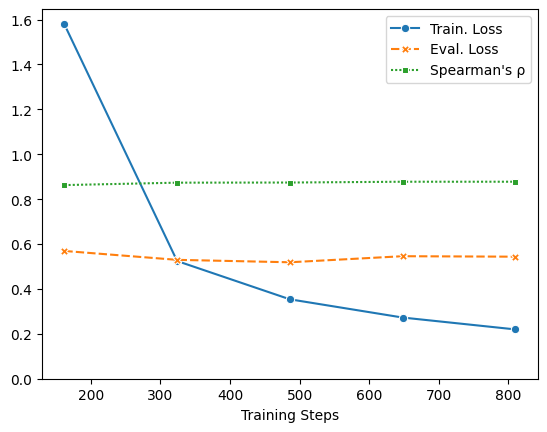

In [31]:
import seaborn as sns

data = training_history_bert_base[["loss", "eval_loss", "step", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Steps", "Spearman's ρ"]
data = data[:-1]
data = pd.melt(data, ['Training Steps']).dropna()

plot = sns.lineplot(data=data, x="Training Steps", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")

from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training Epochs ({PRE_TRAINED_CHECKPOINT})"))

### 2.4 Evaluation

In [33]:
predictions = trainer.predict(tokenized_dataset["test"])

In [35]:
predictions.metrics

{'test_loss': 0.6145729422569275,
 'test_pearson': 0.869368314743042,
 'test_spearmanr': 0.8548670182033874,
 'test_runtime': 0.8707,
 'test_samples_per_second': 660.426,
 'test_steps_per_second': 20.674}

In [38]:
display(Markdown(f"### Best Model performance:"))
results = pd.DataFrame(
    [training_summary_bert_base.metrics["train_runtime"]]
    + list(best_model_evaluation.values())
    + [predictions.metrics["test_spearmanr"]],
    index=["train_runtime_s"] + list(best_model_evaluation.keys()) + ["test_spearmanr"],
    columns=["our BERT_BASE"],
).drop(
    # Drop runtime measurements
    index=["eval_runtime", "eval_samples_per_second", "eval_steps_per_second", "epoch"]
)

# Achieved scores from original BERT paper:
results["original BERT_BASE"] = ["-", "-", "-", "-", 0.858]
results["original BERT_LARGE"] = ["-", "-", "-", "-", 0.865]
print(
    '"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.'
)
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,original BERT_LARGE
train_runtime_s,166.048800,-,-
eval_loss,0.543666,-,-
eval_pearson,0.880267,-,-
eval_spearmanr,0.877664,-,-
test_spearmanr,0.854867,0.664,0.701


## 3. BERT-Large

In [49]:
PRE_TRAINED_CHECKPOINT = "google-bert/bert-large-uncased"

### 3.1 Tokenization

In [40]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/5174 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/575 [00:00<?, ? examples/s]

In [41]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 3.2 Metrics

In [45]:
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)

metric_for_best_model = _task_to_metric[DATASET_TASK]
metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['pearson', 'spearmanr']" as an evaluation metric for the task stsb


In [46]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 3.3 Training

In [47]:
BATCH_SIZE = 16  # BERT-large might need a smaller batch size

In [48]:
import gc

try:
    del model
    del trainer
except:
    pass


gc.collect()

13102

In [50]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    torch_dtype="auto",
)

from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    learning_rate=2e-5,  # Original paper uses best out of  5e-5, 4e-5, 3e-5, and 2e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
)

from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_bert_large = trainer.train()

--- training_arguments.output_dir='/home/markhun/Development/groups/192.039-2024W/bert/training/glue-stsb/google-bert_bert-large-uncased'
--- training_arguments.metric_for_best_model='spearmanr'


Epoch,Training Loss,Validation Loss,Pearson,Spearmanr
1,1.186900,0.490909,0.888033,0.886955
2,0.368900,0.469156,0.894121,0.891450
3,0.217900,0.501862,0.898588,0.895011
4,0.137300,0.445591,0.898644,0.896011
5,0.097800,0.438654,0.899436,0.896234


In [52]:
training_summary_bert_large

TrainOutput(global_step=1620, training_loss=0.4017596009336872, metrics={'train_runtime': 609.4791, 'train_samples_per_second': 42.446, 'train_steps_per_second': 2.658, 'total_flos': 2948788326617640.0, 'train_loss': 0.4017596009336872, 'epoch': 5.0})

In [53]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_loss': 0.4386541247367859,
 'eval_pearson': 0.8994356393814087,
 'eval_spearmanr': 0.8962336399457412,
 'eval_runtime': 4.8972,
 'eval_samples_per_second': 306.3,
 'eval_steps_per_second': 19.195,
 'epoch': 5.0}

In [54]:
training_history_bert_large = pd.DataFrame(trainer.state.log_history)
training_history_bert_large.epoch = training_history_bert_large.epoch.astype(int)
training_history_bert_large.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_pearson,eval_spearmanr,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,,
1,1.1869,15.439109,0.000016,324,0.490909,0.888033,0.886955,4.8476,309.432,19.391,NaN,NaN,NaN,NaN,NaN
2,0.3689,14.270433,0.000012,648,0.469156,0.894121,0.891450,4.8602,308.628,19.341,NaN,NaN,NaN,NaN,NaN
3,0.2179,34.722183,0.000008,972,0.501862,0.898588,0.895011,4.8516,309.174,19.375,NaN,NaN,NaN,NaN,NaN
4,0.1373,6.412906,0.000004,1296,0.445591,0.898644,0.896011,4.8645,308.357,19.324,NaN,NaN,NaN,NaN,NaN
5,0.0978,7.821063,0.000000,1620,0.438654,0.899436,0.896234,4.8518,309.164,19.374,609.4791,42.446,2.658,2.948788e+15,0.40176


### Loss and Evaluation Metrics over Training Epochs (google-bert/bert-large-uncased)

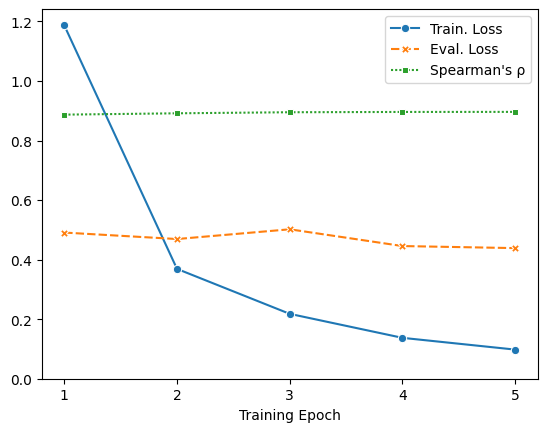

In [56]:
import seaborn as sns

data = training_history_bert_large[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Spearman's ρ"]
data = data[:-1]
data = pd.melt(data, ['Training Epoch']).dropna()

plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_bert_large.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")


from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training Epochs ({PRE_TRAINED_CHECKPOINT})"))

### 3.4 Evaluation

In [57]:
predictions = trainer.predict(tokenized_dataset["test"])

In [58]:
predictions.metrics

{'test_loss': 0.5033445358276367,
 'test_pearson': 0.8870505094528198,
 'test_spearmanr': 0.8735248680831671,
 'test_runtime': 2.4393,
 'test_samples_per_second': 235.724,
 'test_steps_per_second': 14.758}

In [60]:
display(Markdown(f"### Best Model performance:"))
results["our BERT_LARGE"] = [
    training_summary_bert_large.metrics["train_runtime"],
    best_model_evaluation["eval_loss"],
    best_model_evaluation["eval_pearson"],
    best_model_evaluation["eval_spearmanr"],
    predictions.metrics["test_spearmanr"],
]
results = results[
    [
        "our BERT_BASE",
        "original BERT_BASE",
        "our BERT_LARGE",
        "original BERT_LARGE",
    ]
]
print('"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.')
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,our BERT_LARGE,original BERT_LARGE
train_runtime_s,166.048800,-,609.479100,-
eval_loss,0.543666,-,0.438654,-
eval_pearson,0.880267,-,0.899436,-
eval_spearmanr,0.877664,-,0.896234,-
test_spearmanr,0.854867,0.664,0.873525,0.701


## 4. ModernBERT-base

In [67]:
PRE_TRAINED_CHECKPOINT = "answerdotai/ModernBERT-base" 

### 4.1 Tokenization

In [68]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [69]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 4.2 Metrics

In [70]:
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)

metric_for_best_model = _task_to_metric[DATASET_TASK]
metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['pearson', 'spearmanr']" as an evaluation metric for the task stsb


In [71]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 4.3 Training

In [76]:
BATCH_SIZE = 32

In [77]:
import gc

try:
    del model
    del trainer
except:
    pass


gc.collect()

1662

In [78]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    reference_compile=False
)

from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    lr_scheduler_type="linear",
    optim="adamw_torch",
    adam_beta1=0.9,
    adam_beta2=0.98,
    adam_epsilon=1e-6,
    learning_rate=8e-5,  # Original paper recommends 8e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
    bf16=True,
    bf16_full_eval=True,
)

from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [79]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_modernbert_base = trainer.train()

--- training_arguments.output_dir='/home/markhun/Development/groups/192.039-2024W/bert/training/glue-stsb/answerdotai_ModernBERT-base'
--- training_arguments.metric_for_best_model='spearmanr'


Epoch,Training Loss,Validation Loss,Pearson,Spearmanr
1,0.881100,0.504910,0.892087,0.891113
2,0.326500,0.459212,0.896490,0.896086
3,0.155500,0.439354,0.901015,0.899280
4,0.074900,0.406761,0.905178,0.902982
5,0.032500,0.409945,0.904424,0.902871


In [80]:
training_summary_modernbert_base

TrainOutput(global_step=810, training_loss=0.2940904269983739, metrics={'train_runtime': 145.0645, 'train_samples_per_second': 178.334, 'train_steps_per_second': 5.584, 'total_flos': 1237289816506428.0, 'train_loss': 0.2940904269983739, 'epoch': 5.0})

In [81]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_loss': 0.4070499539375305,
 'eval_pearson': 0.9050994515419006,
 'eval_spearmanr': 0.9029992890728747,
 'eval_runtime': 1.4232,
 'eval_samples_per_second': 1053.934,
 'eval_steps_per_second': 33.023,
 'epoch': 5.0}

In [82]:
training_history_modernbert_base = pd.DataFrame(trainer.state.log_history)
training_history_modernbert_base.epoch = training_history_modernbert_base.epoch.astype(int)
training_history_modernbert_base.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_pearson,eval_spearmanr,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,,
1,0.8811,4.139645,0.000064,162,0.504910,0.892087,0.891113,1.4180,1057.829,33.145,NaN,NaN,NaN,NaN,NaN
2,0.3265,2.423972,0.000048,324,0.459212,0.896490,0.896086,1.3737,1091.924,34.214,NaN,NaN,NaN,NaN,NaN
3,0.1555,5.594643,0.000032,486,0.439354,0.901015,0.899280,1.3814,1085.870,34.024,NaN,NaN,NaN,NaN,NaN
4,0.0749,2.013381,0.000016,648,0.406761,0.905178,0.902982,1.4667,1022.738,32.046,NaN,NaN,NaN,NaN,NaN
5,0.0325,0.619322,0.000000,810,0.409945,0.904424,0.902871,1.5253,983.399,30.813,145.0645,178.334,5.584,1.237290e+15,0.29409


### Loss and Evaluation Metrics over Training Epochs (answerdotai/ModernBERT-base)

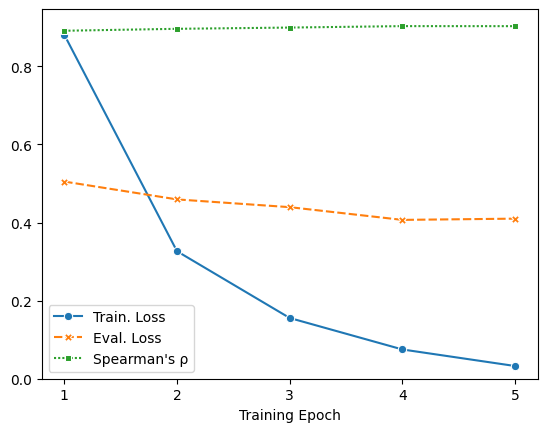

In [83]:
import seaborn as sns

data = training_history_modernbert_base[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Spearman's ρ"]
data = data[:-1]
data = pd.melt(data, ['Training Epoch']).dropna()

plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_modernbert_base.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")


from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training Epochs ({PRE_TRAINED_CHECKPOINT})"))

### 3.4 Evaluation

In [84]:
predictions = trainer.predict(tokenized_dataset["test"])

In [85]:
predictions.metrics

{'test_loss': 0.45781663060188293,
 'test_pearson': 0.8936424255371094,
 'test_spearmanr': 0.8808561475208558,
 'test_runtime': 0.707,
 'test_samples_per_second': 813.238,
 'test_steps_per_second': 25.458}

In [87]:
display(Markdown(f"### Best Model performance:"))
results["our ModernBERT_BASE"] = [
    training_summary_modernbert_base.metrics["train_runtime"],
    best_model_evaluation["eval_loss"],
    best_model_evaluation["eval_pearson"],
    best_model_evaluation["eval_spearmanr"],
    predictions.metrics["test_spearmanr"],
]
results = results[
    [
        "our BERT_BASE",
        "original BERT_BASE",
        "our ModernBERT_BASE",
        "our BERT_LARGE",
        "original BERT_LARGE",
    ]
]
print('"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.')
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,our ModernBERT_BASE,our BERT_LARGE,original BERT_LARGE
train_runtime_s,166.048800,-,145.064500,609.479100,-
eval_loss,0.543666,-,0.407050,0.438654,-
eval_pearson,0.880267,-,0.905099,0.899436,-
eval_spearmanr,0.877664,-,0.902999,0.896234,-
test_spearmanr,0.854867,0.664,0.880856,0.873525,0.701


## 5. ModernBERT-Large

In [88]:
PRE_TRAINED_CHECKPOINT = "answerdotai/ModernBERT-large" 

### 4.1 Tokenization

In [89]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

def tokenize_func(item):
    """Tokenize passed item. 
    
    Depending on dataset task the passed item will either contain one sentence or two sentences.
    In the last case the two sentences will be appended via a [SEP] token.
    """
    if second_sentence_key is None:
        return tokenizer(item[first_sentence_key], add_special_tokens=True, truncation=True)
    else:
        return tokenizer(item[first_sentence_key], item[second_sentence_key], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Map:   0%|          | 0/5174 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/575 [00:00<?, ? examples/s]

In [90]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 4.2 Metrics

In [91]:
import evaluate

metric = evaluate.load(DATASET_NAME, DATASET_TASK)

metric_for_best_model = _task_to_metric[DATASET_TASK]
metric_names = get_metric_name_for_specific_task()
print(f'We will use "{metric_names}" as an evaluation metric for the task {DATASET_TASK}')

We will use "['pearson', 'spearmanr']" as an evaluation metric for the task stsb


/home/markhun/Development/2024W-DLNLP-BERT/../groups/192.039-2024W/bert/huggingface/cache/modules/evaluate_modules/metrics/evaluate-metric--glue/05234ba7acc44554edcca0978db5fa3bc600eeee66229abe79ff9887eacaf3ed/glue.py:97: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr = float(pearsonr(preds, labels)[0])
/home/markhun/Development/2024W-DLNLP-BERT/../groups/192.039-2024W/bert/huggingface/cache/modules/evaluate_modules/metrics/evaluate-metric--glue/05234ba7acc44554edcca0978db5fa3bc600eeee66229abe79ff9887eacaf3ed/glue.py:98: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr = float(spearmanr(preds, labels)[0])


In [92]:
assert metric_for_best_model in metric_names, "Metric to optimize for not found in evaluation metrics provided by GLUE"

### 4.3 Training

In [93]:
BATCH_SIZE = 16

In [94]:
import gc

try:
    del model
    del trainer
except:
    pass


gc.collect()
torch.cuda.empty_cache()

In [95]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    reference_compile=False
)

from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=(TRAIN_OUTPUT_DIR / PRE_TRAINED_CHECKPOINT.replace("/", "_")).resolve(),
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    lr_scheduler_type="linear",
    optim="adamw_torch",
    adam_beta1=0.9,
    adam_beta2=0.98,
    adam_epsilon=1e-6,
    learning_rate=8e-5,  # Original paper recommends 8e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    save_total_limit = 3,  # Keep at most the three checkpoints (latest + best one)
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
    bf16=True,
    bf16_full_eval=True,
)

from transformers import Trainer

validation_key = "validation_mismatched" if DATASET_TASK == "mnli-mm" else "validation_matched" if DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [96]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
print(f"--- {training_arguments.metric_for_best_model=}")
training_summary_modernbert_large = trainer.train()

--- training_arguments.output_dir='/home/markhun/Development/groups/192.039-2024W/bert/training/glue-stsb/answerdotai_ModernBERT-large'
--- training_arguments.metric_for_best_model='spearmanr'


Epoch,Training Loss,Validation Loss,Pearson,Spearmanr
1,0.751200,0.490269,0.901330,0.902979
2,0.325800,0.624647,0.894932,0.898593
3,0.182700,0.392652,0.910128,0.908240
4,0.096200,0.369437,0.914455,0.912071
5,0.042500,0.371989,0.914783,0.912904


In [97]:
training_summary_modernbert_large

TrainOutput(global_step=1620, training_loss=0.27967402787856116, metrics={'train_runtime': 505.3323, 'train_samples_per_second': 51.194, 'train_steps_per_second': 3.206, 'total_flos': 3419320398536412.0, 'train_loss': 0.27967402787856116, 'epoch': 5.0})

In [98]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

{'eval_loss': 0.37229329347610474,
 'eval_pearson': 0.9147282838821411,
 'eval_spearmanr': 0.9128897676243384,
 'eval_runtime': 3.1977,
 'eval_samples_per_second': 469.09,
 'eval_steps_per_second': 29.396,
 'epoch': 5.0}

In [99]:
training_history_modernbert_large = pd.DataFrame(trainer.state.log_history)
training_history_modernbert_large.epoch = training_history_modernbert_large.epoch.astype(int)
training_history_modernbert_large.groupby("epoch").first()

,loss,grad_norm,learning_rate,step,eval_loss,eval_pearson,eval_spearmanr,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
epoch,,,,,,,,,,,,,,,
1,0.7512,11.961430,0.000064,324,0.490269,0.901330,0.902979,3.5021,428.312,26.841,NaN,NaN,NaN,NaN,NaN
2,0.3258,6.373748,0.000048,648,0.624647,0.894932,0.898593,3.4741,431.768,27.057,NaN,NaN,NaN,NaN,NaN
3,0.1827,4.507772,0.000032,972,0.392652,0.910128,0.908240,3.5064,427.784,26.808,NaN,NaN,NaN,NaN,NaN
4,0.0962,4.354125,0.000016,1296,0.369437,0.914455,0.912071,4.0091,374.153,23.447,NaN,NaN,NaN,NaN,NaN
5,0.0425,1.127213,0.000000,1620,0.371989,0.914783,0.912904,3.4545,434.216,27.211,505.3323,51.194,3.206,3.419320e+15,0.279674


### Loss and Evaluation Metrics over Training Epochs (answerdotai/ModernBERT-large)

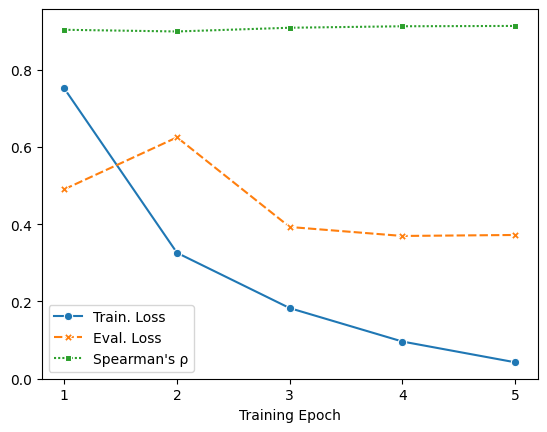

In [100]:
import seaborn as sns

data = training_history_modernbert_large[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Spearman's ρ"]
data = data[:-1]
data = pd.melt(data, ['Training Epoch']).dropna()

plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set(xticks=list(set(training_history_modernbert_large.epoch)))
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")


from IPython.display import Markdown, display
display(Markdown(f"### Loss and Evaluation Metrics over Training Epochs ({PRE_TRAINED_CHECKPOINT})"))

### 3.4 Evaluation

In [101]:
predictions = trainer.predict(tokenized_dataset["test"])

In [102]:
predictions.metrics

{'test_loss': 0.36105039715766907,
 'test_pearson': 0.9168518781661987,
 'test_spearmanr': 0.9078382799825393,
 'test_runtime': 1.4491,
 'test_samples_per_second': 396.786,
 'test_steps_per_second': 24.842}

In [103]:
display(Markdown(f"### Best Model performance:"))
results["our ModernBERT_LARGE"] = [
    training_summary_modernbert_large.metrics["train_runtime"],
    best_model_evaluation["eval_loss"],
    best_model_evaluation["eval_pearson"],
    best_model_evaluation["eval_spearmanr"],
    predictions.metrics["test_spearmanr"],
]
results = results[
    [
        "our BERT_BASE",
        "original BERT_BASE",
        "our ModernBERT_BASE",
        "our BERT_LARGE",
        "original BERT_LARGE",
        "our ModernBERT_LARGE",
    ]
]
print('"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.')
results

### Best Model performance:

"BERT_BASE" and "BERT_LARGE" performance on GLUE testing data as reported in original paper.


,our BERT_BASE,original BERT_BASE,our ModernBERT_BASE,our BERT_LARGE,original BERT_LARGE,our ModernBERT_LARGE
train_runtime_s,166.048800,-,145.064500,609.479100,-,505.332300
eval_loss,0.543666,-,0.407050,0.438654,-,0.372293
eval_pearson,0.880267,-,0.905099,0.899436,-,0.914728
eval_spearmanr,0.877664,-,0.902999,0.896234,-,0.912890
test_spearmanr,0.854867,0.664,0.880856,0.873525,0.701,0.907838


# Summary

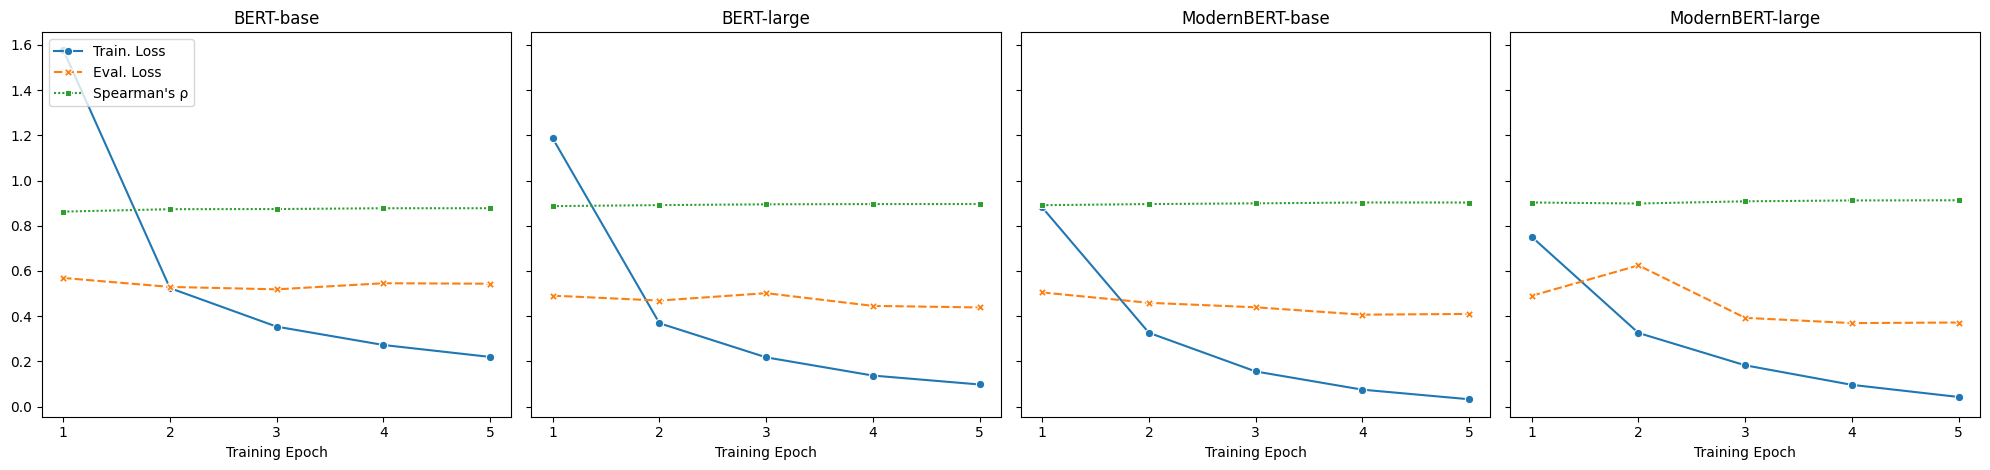

In [104]:
import matplotlib.pyplot as plt

titles = ["BERT-base", "BERT-large", "ModernBERT-base", "ModernBERT-large"]
training_histories = [training_history_bert_base, training_history_bert_large, training_history_modernbert_base, training_history_modernbert_large]

fig, axes = plt.subplots(ncols=len(training_histories), sharey=True)

def draw_loss_eval_plot(title, history, ax):
    data = history[["loss", "eval_loss", "epoch", f"eval_{metric_for_best_model}"]]
    data.columns = ["Train. Loss", "Eval. Loss", "Training Epoch", "Spearman's ρ"]
    data = data[:-1]
    data = pd.melt(data, ['Training Epoch']).dropna()

    plot = sns.lineplot(data=data, x="Training Epoch", y="value", hue="variable", style="variable", markers=True, ax=ax)
    plot.set_ylabel("")
    plot.set(xticks=list(set(history.epoch)))
    plot.legend(title="", loc='upper left')
    plot.set_title(title)

for title, history, ax in zip(titles, training_histories, axes):
    draw_loss_eval_plot(title, history, ax)

for ax in axes[1:]:
    ax.get_legend().remove()

fig.set_figwidth(20)
fig.tight_layout()

In [105]:
results

,our BERT_BASE,original BERT_BASE,our ModernBERT_BASE,our BERT_LARGE,original BERT_LARGE,our ModernBERT_LARGE
train_runtime_s,166.048800,-,145.064500,609.479100,-,505.332300
eval_loss,0.543666,-,0.407050,0.438654,-,0.372293
eval_pearson,0.880267,-,0.905099,0.899436,-,0.914728
eval_spearmanr,0.877664,-,0.902999,0.896234,-,0.912890
test_spearmanr,0.854867,0.664,0.880856,0.873525,0.701,0.907838


In [106]:
speedup = results["our BERT_BASE"]["train_runtime_s"] / results["our ModernBERT_BASE"]["train_runtime_s"] 
speedup

np.float64(1.1446549638264358)

`ModernBERT-base` shows prediction performance comparable to `BERT-large`, while providing a __1.14x speedup__ in training time compare to `BERT-base`.